# 协同过滤入门
http://python.jobbole.com/85516/

#### 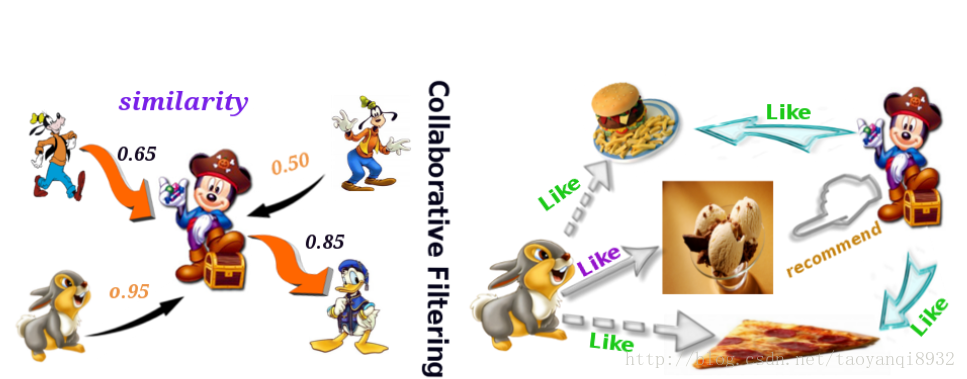

#### 导入数据集

In [2]:
import numpy as np
import pandas as pd

header = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv("C:/Pdata/shixi/ml-latest-small/ratings.csv")

#### 由于数据集和网页的例子不同，需要转换

In [3]:
df.columns=('user_id', 'item_id', 'rating', 'timestamp')
n_users = df.user_id.unique().shape[0]
n_items = df.item_id.unique().shape[0]
print ('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)  )
df.iloc[[1,3,88]]

Number of users = 671 | Number of movies = 9066


,user_id,item_id,rating,timestamp
1,1,1029,3.0,1260759179
3,1,1129,2.0,1260759185
88,2,588,3.0,835355441


#### 直接用代码会在构建相似度矩阵时报错，因为item_ID超出索引，将索引作为新的item_id

In [78]:
item_new=df[['item_id']].drop_duplicates(keep='first', inplace=False) #去重
item_new=item_new.sort_values(['item_id'],ascending=[True]) #排序
item_new['item_id_new']=range(1,9067) #新旧ID
df2=pd.merge(df, item_new, how='right', left_on='item_id',right_on='item_id') #合并，改名后正常使用
df2.columns=('user_id', 'item_id_old', 'rating', 'timestamp','item_id')
df2.head()

,user_id,item_id_old,rating,timestamp,item_id
0,1,31,2.5,1260759144,31
1,7,31,3.0,851868750,31
2,31,31,4.0,1273541953,31
3,32,31,4.0,834828440,31
4,36,31,3.0,847057202,31


#### 含义
用户-产品协同过滤: 找到相似的用户，看他们的喜好作为推荐：像你一样的人也喜欢……”
产品-产品协同过滤: 找到喜欢这个产品的用户，看他们的喜好作为推荐：“喜欢这个东西的人也喜欢……”

In [75]:
from sklearn import cross_validation as cv;
train_data, test_data = cv.train_test_split(df2, test_size=0.25)#分测试集和训练集

#### 新建2个相似度矩阵，训练集和测试集

In [73]:
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():    #通过这种方式遍历df的行
    train_data_matrix[line[1]-1,line[5]-1] = line[3]  
 
test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1,line[5]-1] = line[3]

#### 计算相似度
使用sklearn的pairwise_distances函数来计算余弦相似性,原因在于：

欧氏距离能够体现个体数值特征的绝对差异，所以更多的用于需要从维度的数值大小中体现差异的分析，如使用用户行为指标分析用户价值的相似度或差异。

余弦距离更多的是从方向上区分差异，而对绝对的数值不敏感，更多的用于使用用户对内容评分来区分兴趣的相似度和差异，同时修正了用户间可能存在的度量标准不统一的问题（因为余弦距离对绝对数值不敏感）。

此外，这里是通过所有用户的评分来计算相似度，因此是“协同”，而CB中计算相似度是根据项目本身的特征


In [7]:
from sklearn.metrics.pairwise import pairwise_distances
user_similarity = pairwise_distances(train_data_matrix, metric='cosine') #用户之间的余弦相似度（取值0（完全不一样）到1（完全一样）） 671*671
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine') # 项目之间的余弦距离 9066*9066

#### 预测评分
基于用户的预测：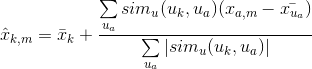

    预测用户k对电影m的评分，等于用户k对所有电影的均值，加上加权的其他用户对m的评分均值，与用户k越相近的用户权重越高

    每个人的默认评分基础不同（有的人习惯打三星，有的习惯4星），所以通过均值的偏差更为准确





 基于项目的预测：

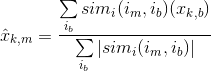

    预测用户k对电影m的评分，等于用户k对其他所有电影评分的加权，与m越相近的电影权重越高

In [8]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        #用户对所有电影的平均评分，减小个人偏向极端性造成的影响
        mean_user_rating = ratings.mean(axis=1)
        #用np.newaxis保持格式一致，实际就是转置
        # 减去均值的评分矩阵
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis])      
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

### 预测结果
计算过程很久，可能不适合大型数据的预测

In [9]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

### 预测结果有效性验证

In [10]:
from sklearn.metrics import mean_squared_error
from math import sqrt
def rmse(prediction, ground_truth): #加一个开方运算
    prediction = prediction[ground_truth.nonzero()].flatten()  #把所有实际有评分的用户-电影整平为list
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [11]:
print ('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print ('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.3650344441940607
Item-based CF RMSE: 3.581185043626987


### 优缺点
简单易理解，结果准确性可以度量

但是无法冷启动（每次新加入对象，都要重新跑一边模型）
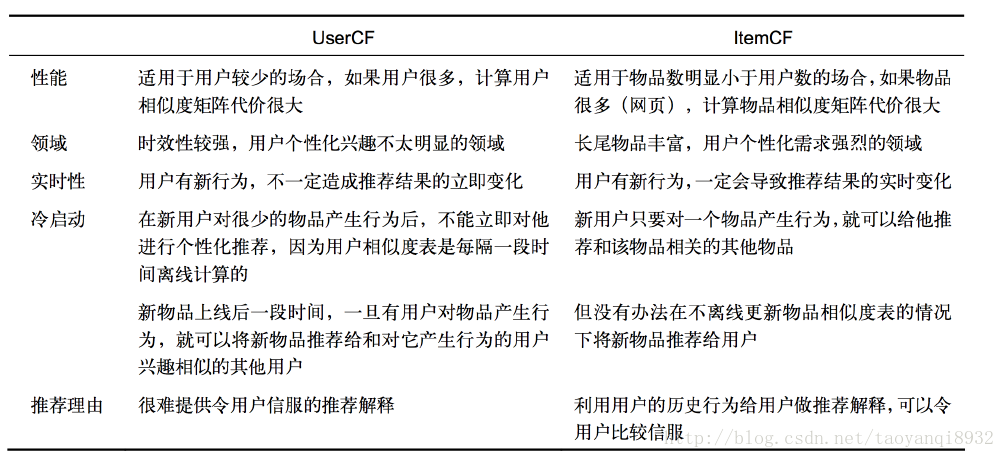

## 以上是基于内存的协同过滤，下面是基于模型的

#### 计算数据集的稀疏度
例如：943个用户对1682个电影的100000条评分记录

稀疏性：1-(100000/(943*1682))=93.69%

In [12]:
sparsity=round(1.0-len(df2)/float(n_users*n_items),3)
print('The sparsity level of MovieLens100K is ' +  str(sparsity*100) + '%')


The sparsity level of MovieLens100K is 98.4%


VSD分解，这里用Vt是应为在主成分分析里，XV=US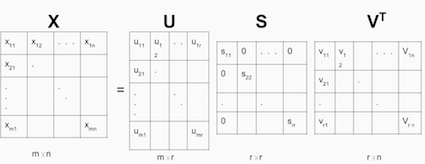

 取前k个奇异值进行估计（S的规模为r*r，算是降维了）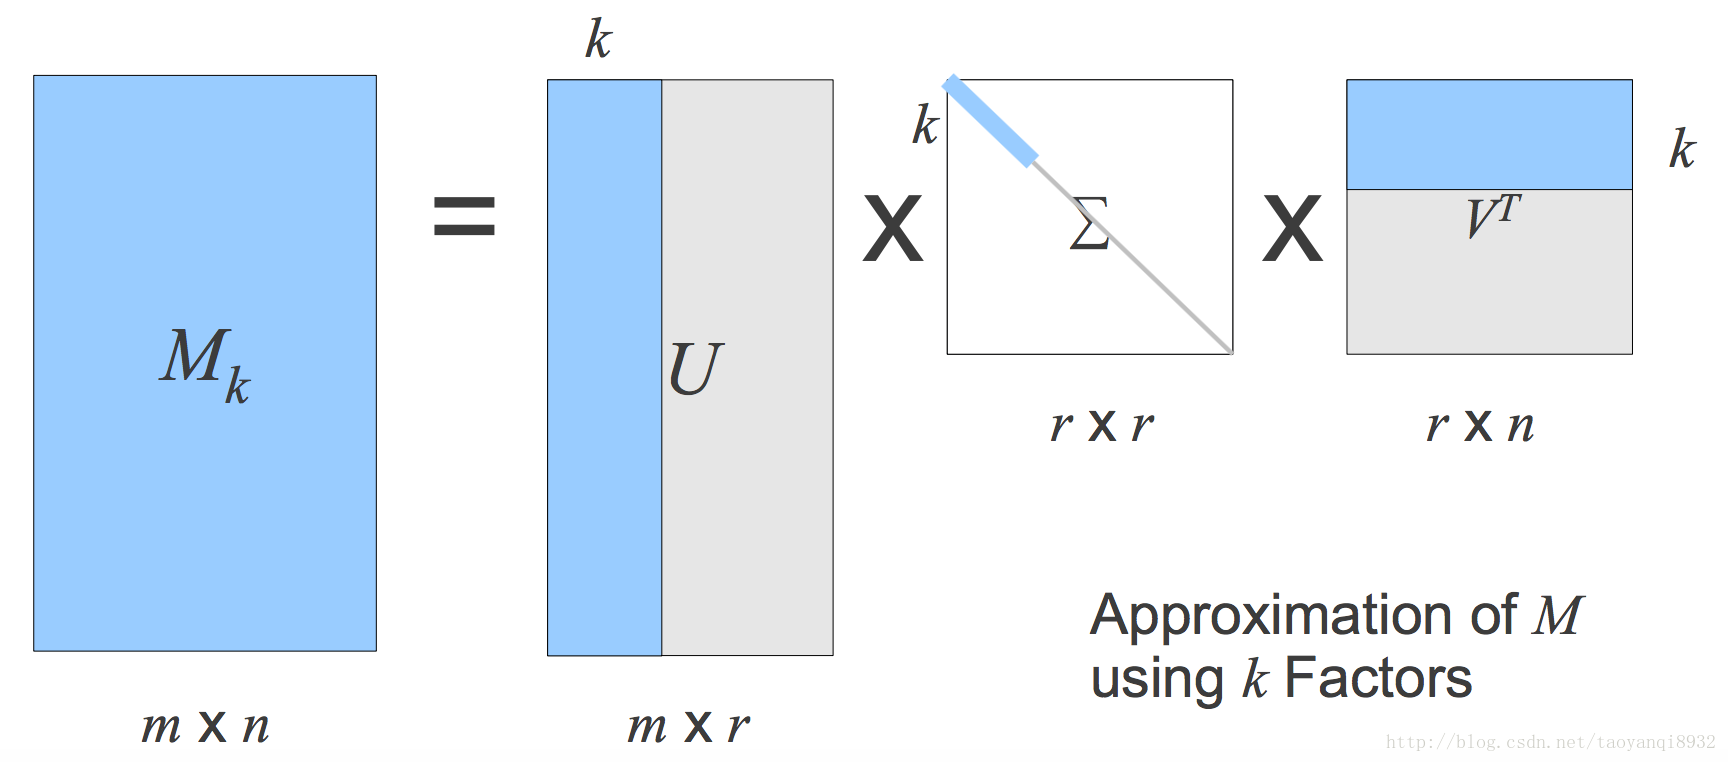

In [13]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 10)#这里k就是前k大奇异值，用前k个奇异值代表全部
s_diag_matrix=np.diag(s) #计算获得的s是array
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print ('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 3.0382852200186683


### 简单来讲，奇异值分解后的近似矩阵就是估计矩阵

### CF的优缺点
优点

•没有必要手动创建特征。

缺点

•如果没有大量的项目和用户，它不能正常工作。

协同过滤方法通过使用数据，来发现类似的用户和电影，这将导致热门电影比小众电影更容易被推荐。

由于新上映的电影没有太多的使用数据，指望协同过滤向用户推荐任何新电影很不现实。（冷启动）



### 基于内容过滤的优缺点
“基于内容的推荐”是一个回归问题，我们把电影内容作为特征，对用户对电影的评分做预测。

优点

•它不需要大量的用户。

缺点

•定义正确的特征可能是一个挑战。

•缺乏“意外的惊喜”